In [1]:
import pandas as pd
import xarray as xr
import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import mean_squared_error, r2_score

from dirs import prepdir

In [2]:

meta_data = xr.open_dataset(prepdir + 'wrfinput_d02')
masks     = xr.open_dataset(prepdir + 'basin_masks_filtered.nc')
sweBC     = xr.open_dataarray(prepdir + 'snowmaxBC.nc')

In [3]:
## Read in static fields

lat_wrf    = meta_data.variables["XLAT"][0,:,:]
lon_wrf    = meta_data.variables["XLONG"][0,:,:]
z_wrf      = meta_data.variables["HGT"][0,:,:]
vgtyp_wrf  = meta_data.variables["IVGTYP"][0,:,:] ## Table 2: IGBP-Modified MODIS 20-category Land Use Categories
vegfra_wrf = meta_data.variables["VEGFRA"][0,:,:] ## Average canopy cover

lat_wrf    = xr.DataArray(lat_wrf, dims=["lat2d", "lon2d"])
lon_wrf    = xr.DataArray(lon_wrf, dims=["lat2d", "lon2d"])
z_wrf      = xr.DataArray(z_wrf, dims=["lat2d", "lon2d"])
vgtyp_wrf  = xr.DataArray(vgtyp_wrf, dims=["lat2d", "lon2d"]) 
vegfra_wrf = xr.DataArray(vegfra_wrf, dims=["lat2d", "lon2d"])

## Compute slope and aspect
myslopx, myslopy = np.gradient(z_wrf, 9000)
slope_wrf = np.degrees(np.arctan(np.sqrt(myslopx**2 + myslopy**2)))
aspect_wrf = np.degrees(np.arctan2(-myslopy,myslopx))
## Convert aspect to compass direction (clockwise from north)
aspect_q2 = (aspect_wrf > 90) & (aspect_wrf <= 180) ## [90, 180]
aspect_wrf = 90.0 - aspect_wrf
aspect_wrf[aspect_q2] = 360.0 + aspect_wrf[aspect_q2]


gcms = ['cesm2','mpi-esm1-2-lr','cnrm-esm2-1',
        'ec-earth3-veg','fgoals-g3','ukesm1-0-ll',
        'canesm5','access-cm2','ec-earth3',]


variants = ['r11i1p1f1','r7i1p1f1','r1i1p1f2',
            'r1i1p1f1','r1i1p1f1','r2i1p1f2',
            'r1i1p2f1','r5i1p1f1','r1i1p1f1',]

gcm_variants = [f'{item1}_{item2}_ssp370' for item1, item2 in zip(gcms, variants)]

In [4]:
def update_rect (basin_imin, basin_imax, basin_jmin, basin_jmax):
    """Update the bounding box around the basin such that 
    the dimensions are multiples of 8.
    """
    lat_extent = basin_imax - basin_imin
    lat_pad = int(8*(np.ceil(lat_extent/8) )) - lat_extent

    basin_imin = basin_imin - int(np.floor(lat_pad/2))
    basin_imax = basin_imax + int(np.ceil(lat_pad/2))
    # lat_extent = basin_imax - basin_imin

    lon_extent = basin_jmax - basin_jmin
    lon_pad = int(8*(np.ceil(lon_extent/8) )) - lon_extent

    basin_jmin = basin_jmin - int(np.floor(lon_pad/2))
    basin_jmax = basin_jmax + int(np.ceil(lon_pad/2))
    # lon_extent = basin_jmax - basin_jmin
    
    return basin_imin, basin_imax, basin_jmin, basin_jmax

def get_basin_rect(basin_id, update_shape=True):

    basinmask = masks.basin_masks[basin_id]
    mask = basinmask.data.astype(bool)

    ## Extract a rectangle encompassing the basin to maintain spatial structure
    basin_ii, basin_jj = np.nonzero(mask)
    basin_imin, basin_imax = basin_ii.min(), basin_ii.max()+1
    basin_jmin, basin_jmax = basin_jj.min(), basin_jj.max()+1
    
    if update_shape:
        return update_rect(basin_imin, basin_imax, basin_jmin, basin_jmax)
    
    return basin_imin, basin_imax, basin_jmin, basin_jmax

def get_dataarray_basin (basin_id, dataarray):
    basin_imin, basin_imax, basin_jmin, basin_jmax = get_basin_rect(basin_id)
    return dataarray.sel(lat2d=np.arange(basin_imin, basin_imax), lon2d=np.arange(basin_jmin, basin_jmax))

def get_dataarray_gcm_year (gcm_id, years, dataarray):
    return dataarray.sel(gcm=gcm, time=years)
    # return dataarray[gcm_id, years,:].flatten()

In [5]:
train_length = 20
# test_years = np.arange(2001, 2101, 1)
test_years = np.arange(2001, 2101, 5)
train_years = [range(item-train_length, item) for item in test_years]

Data_1 = ['knn_snotel', 'Longitude', 'Latitude']
Data_2 = Data_1 + ['Elevation', 'Slope', 'Aspect', 'Veg-Type', 'Veg-Frac']
Data_3 = Data_2 + ['Cum-fSCA']
Data_4 = Data_3 + ['Cum-precip', 'Cum-snow', 'Mean-temp', 'PDD-sum']
Data_5 = Data_4 + ['ASO-proxy']

In [24]:
pred_combo_list = ['Data_1', 'Data_2', 'Data_3', 'Data_4', 'Data_5']

# err_xr = xr.DataArray(np.zeros((masks.basin.size, 9, test_years.size, 2, 5, 2)), dims=['basin','gcm','test_year','model', 'pred_combo', 'metric'],
#             coords={'basin' : masks.basin.values, 'gcm':gcm_variants,  'test_year' : test_years, 'model':['linreg', 'RF'],
#                     'pred_combo':pred_combo_list, 'metric':['rmse', 'r2']})

err_xr = xr.DataArray(np.zeros((1, 9, test_years.size, 1, 5, 2)), dims=['basin','gcm','test_year','model', 'pred_combo', 'metric'],
            coords={'basin' : masks.basin.values[0:1], 'gcm':gcm_variants,  'test_year' : test_years, 'model':['Unet'],
                    'pred_combo':pred_combo_list, 'metric':['rmse', 'r2']})

# src_folder = '/pscratch/sd/u/umital/fate-of-snotels/Fig4_Unet_preds_test/'
src_folder = '/global/cfs/cdirs/m4099/fate-of-snotel/wrfdata/umital/Fig4_results/Fig4_Unet_preds_test/'

In [25]:
%%time
for basin_id in range(0,1):
# for basin_id in range(masks.basin.size):

### Will loop over basin_id

    basinname = masks.basin.values[basin_id]

    ### Take subset of met and swe data here

    swe_basin             = get_dataarray_basin (basin_id, sweBC)

    for gcm_id in range(0,9):
    ### Will loop over gcm_id, this will be nested inside basin_id loop
        gcm = gcm_variants[gcm_id]
        print (f"Modeling {basin_id}_{basinname}_{gcm}")
        for test_id in range(test_years.size):

        ### Will loop over test_id, this will be nested inside gcm_id loop
            
            
            Test_SWE = get_dataarray_gcm_year (gcm_id, test_years[test_id], swe_basin).expand_dims(dim='channels', axis=-1)
            ### Need to scale the data before we start training.
            
            # for data_id, data_var in enumerate([Data_2]):
            for data_id, data_var in enumerate([Data_1, Data_2, Data_3, Data_4, Data_5]):
                ## Sometimes U-Net weights are not initialized optimally which can affect the results. When that happens,
                ## the model loss doesn't improve and model terminates after < 20 epochs. This while loop checks
                ## for early termination and forces a redo if fewer than 20 epochs were used.
                y_pred = np.load(src_folder + f'{basin_id}_{basinname}_{gcm}_{test_years[test_id]}_{data_id}_Unet.npy')
                err_xr.loc[dict(basin=basinname, gcm=gcm, test_year=test_years[test_id], 
                            model='Unet', pred_combo=pred_combo_list[data_id], metric='rmse')] = mean_squared_error(Test_SWE[:,:,0], y_pred)**0.5
                
                err_xr.loc[dict(basin=basinname, gcm=gcm, test_year=test_years[test_id], 
                            model='Unet', pred_combo=pred_combo_list[data_id], metric='r2')] = r2_score(Test_SWE[:,:,0], y_pred)**0.5
                


Modeling 0_Gunnison_cesm2_r11i1p1f1_ssp370
Modeling 0_Gunnison_mpi-esm1-2-lr_r7i1p1f1_ssp370
Modeling 0_Gunnison_cnrm-esm2-1_r1i1p1f2_ssp370
Modeling 0_Gunnison_ec-earth3-veg_r1i1p1f1_ssp370
Modeling 0_Gunnison_fgoals-g3_r1i1p1f1_ssp370
Modeling 0_Gunnison_ukesm1-0-ll_r2i1p1f2_ssp370
Modeling 0_Gunnison_canesm5_r1i1p2f1_ssp370


<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power


Modeling 0_Gunnison_access-cm2_r5i1p1f1_ssp370
Modeling 0_Gunnison_ec-earth3_r1i1p1f1_ssp370
CPU times: user 1.59 s, sys: 173 ms, total: 1.76 s
Wall time: 2.07 s


<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power
<timed exec>:34: RuntimeWarning: invalid value encountered in scalar power


In [39]:
err_xr.isel(metric=1, gcm=8, basin=0, model=0)

<xarray.DataArray (test_year: 20, pred_combo: 5)>
array([[0.96034889, 0.95774974, 0.95685525, 0.97107395, 0.98408915],
       [0.96560084, 0.96952039, 0.95714847, 0.96475632, 0.97429186],
       [0.97303855, 0.97349316, 0.95901737, 0.97268386, 0.97798923],
       [0.98113804, 0.98066346, 0.9651247 , 0.96230461, 0.97000178],
       [0.98150377, 0.97222858, 0.96986293, 0.95440946, 0.96378978],
       [0.97434119, 0.96387652, 0.90273818, 0.94464902, 0.95873836],
       [0.92728797, 0.9386572 , 0.9361942 , 0.94362231, 0.8952627 ],
       [0.54633459, 0.92052319, 0.95338505, 0.97507136, 0.97231126],
       [0.97687216, 0.96680849, 0.84380642, 0.89337631, 0.91507814],
       [0.95498483, 0.97296802, 0.83840258, 0.95430308, 0.94943075],
       [0.9198808 , 0.88573675, 0.93299164, 0.92661317, 0.95660397],
       [0.96267981, 0.95655224, 0.96151465, 0.93460704, 0.94231704],
       [0.978027  , 0.97333333, 0.95586982, 0.98159185, 0.97149066],
       [0.95013367, 0.93533419, 0.93199141, 0.92687756, 0.86620893],
       [0.97525838, 0.88987254, 0.92580816, 0.8800594 , 0.89455825],
       [0.28222252,        nan,        nan,        nan,        nan],
       [       nan, 0.32438881, 0.52342946, 0.92061608, 0.91575534],
       [0.92143754, 0.91996007, 0.91817592, 0.95615416, 0.93722359],
       [0.78234644, 0.82763734, 0.91095849, 0.87449229, 0.9200083 ],
       [0.97817004, 0.97401788, 0.96641018, 0.95655604, 0.96725837]])
Coordinates:
    basin       <U8 'Gunnison'
    gcm         <U29 'ec-earth3_r1i1p1f1_ssp370'
  * test_year   (test_year) int64 2001 2006 2011 2016 ... 2081 2086 2091 2096
    model       <U4 'Unet'
  * pred_combo  (pred_combo) <U6 'Data_1' 'Data_2' 'Data_3' 'Data_4' 'Data_5'
    metric      <U4 'r2'

In [38]:
err_xr.to_netcdf('error_Unet_Gunnison.nc')

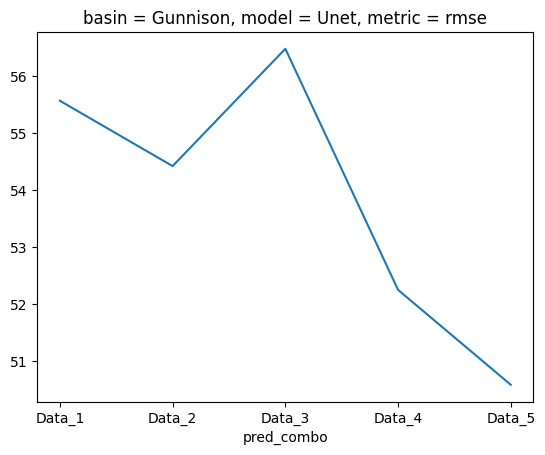

In [49]:
err_xr.isel(basin=0, metric=0, model=0).mean(dim=['gcm', 'test_year']).plot()

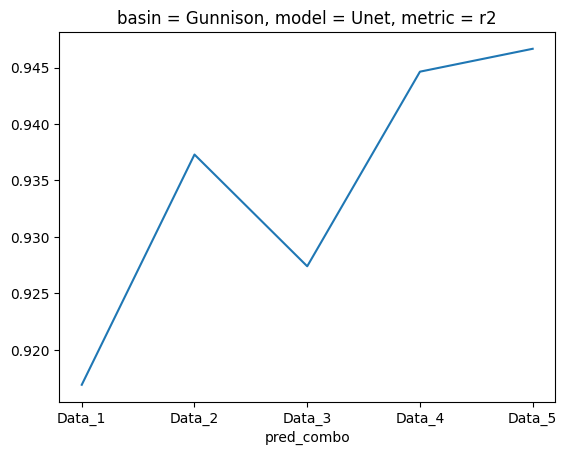

In [50]:
err_xr.isel(basin=0, metric=1, model=0).mean(dim=['gcm', 'test_year']).plot()